In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, subprocess
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools

In [2]:
Het_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/500000")


In [3]:
view_df = pd.DataFrame({'chrom': Het_clr_500kb.chromnames,
                        'start': 0,
                        'end': Het_clr_500kb.chromsizes.values,
                        'name': Het_clr_500kb.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr1,0,195471971,chr1
1,chr2,0,182113224,chr2
2,chr3,0,160039680,chr3
3,chr4,0,156508116,chr4
4,chr5,0,151834684,chr5
...,...,...,...,...
61,JH584300.1,0,182347,JH584300.1
62,JH584301.1,0,259875,JH584301.1
63,JH584302.1,0,155838,JH584302.1
64,JH584303.1,0,158099,JH584303.1


In [4]:
Het_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.bins.gc.500000.tsv'
Het_genome_gc_500kb=pd.read_csv(Het_genome_gc_500kb_file, sep='\t')


Het_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.500000.cis.lam.txt']
Het_cis_eigs_eigenvectors_500kb=pd.read_csv(Het_cis_eigs_500kb_files[0], sep='\t')
with open(Het_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Het_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Het_cis_eigs_results_500kb = [Het_cis_eigs_eigenvalues,Het_cis_eigs_eigenvectors_500kb]
Het_eigenvector_track_500kb =Het_cis_eigs_results_500kb[1][['chrom','start','end','E1']]


In [5]:
Het_cvd_500kb = cooltools.expected_cis(
        clr=Het_clr_500kb,
        view_df=view_df,
    nproc=40
)
display(Het_cvd_500kb)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,0,NaN,391,384,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,500000,0.000304,390,382,NaN,NaN,NaN,NaN,0.000300,0.000304
2,chr1,chr1,2,1000000,0.026380,389,381,541695.0,10.742490,1392.532134,0.028196,0.025751,0.026380
3,chr1,chr1,3,1500000,0.016328,388,380,315661.0,6.189804,813.559278,0.016289,0.015911,0.016328
4,chr1,chr1,4,2000000,0.011143,387,379,213902.0,4.191813,552.718346,0.011060,0.010803,0.011143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,JH584300.1,JH584300.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
5504,JH584301.1,JH584301.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
5505,JH584302.1,JH584302.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
5506,JH584303.1,JH584303.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each


In [7]:
Het_interaction_sum_500kb, Het_interaction_count_500kb =  cooltools.saddle(
        Het_clr_500kb,
        Het_cvd_500kb,
        Het_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


In [8]:
value_strength_b_a_500kb = Het_interaction_sum_500kb/Het_interaction_count_500kb
print(value_strength_b_a_500kb)
value_strength_b_a_500kb.shape

[[4.45041988 3.64879288 3.18855977 ... 0.19970373 0.18545291 0.11406136]
 [3.64879288 3.34966304 2.8904533  ... 0.19224838 0.1759625  0.13994318]
 [3.18855977 2.8904533  2.67522057 ... 0.1830805  0.18110835 0.13593885]
 ...
 [0.19970373 0.19224838 0.1830805  ... 2.07246527 2.18391867 2.53354821]
 [0.18545291 0.1759625  0.18110835 ... 2.18391867 2.47006963 2.71378804]
 [0.11406136 0.13994318 0.13593885 ... 2.53354821 2.71378804 3.57760362]]


(40, 40)

In [9]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

#     # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["ax_cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        print('cbar')

        cb = plt.colorbar(img, format=MinOneMaxFormatter(), cax=grid["ax_cbar"], **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    grid['ax_heatmap'].grid(False)
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)

    return grid

/tmp/ipykernel_1128349/3843342417.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()


cbar


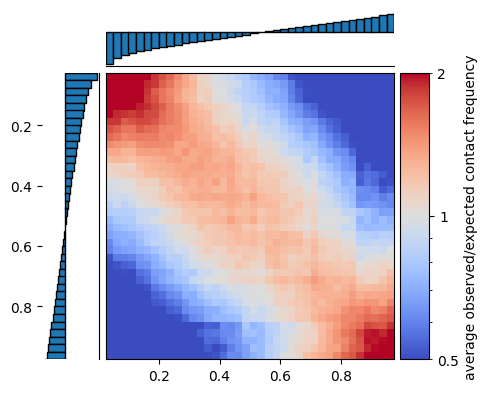

In [10]:
saddleplot(Het_eigenvector_track_500kb,
           Het_interaction_sum_500kb/Het_interaction_count_500kb,
           N_GROUPS,
           qrange=(Q_LO,Q_HI),
           cbar_kws={'label':'average observed/expected contact frequency'}
          );
plt.savefig('../plots/Het_saddle_plot_500kb.pdf', transparent=True, bbox_inches='tight')


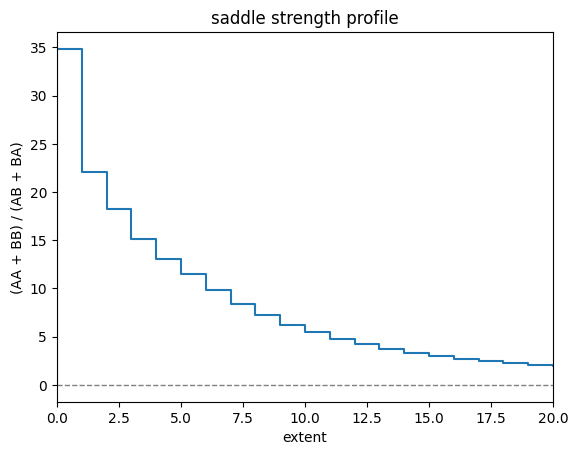

In [11]:
from cooltools.api.saddle import saddle_strength
# at extent=0, this reduces to ((S/C)[0,0] + (S/C)[-1,-1]) / (2*(S/C)[-1,0])

x = np.arange(N_GROUPS + 2)

plt.step(x, saddle_strength(Het_interaction_sum_500kb, Het_interaction_count_500kb), where='pre')

plt.xlabel('extent')
plt.ylabel('(AA + BB) / (AB + BA)')
plt.title('saddle strength profile')
plt.axhline(0, c='grey', ls='--', lw=1) # Q: is there a reason this is 0 not 1?
plt.xlim(0, len(x)//2); # Q: is this less intuitive than showing for all x, as it converges to no difference (i.e. 1)?
plt.show()

In [35]:
Homo_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Homo_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.bins.gc.500000.tsv'
Homo_genome_gc_500kb=pd.read_csv(Homo_genome_gc_500kb_file, sep='\t')


Homo_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.500000.cis.lam.txt']
Homo_cis_eigs_eigenvectors_500kb=pd.read_csv(Homo_cis_eigs_500kb_files[0], sep='\t')
with open(Homo_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Homo_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Homo_cis_eigs_results_500kb = [Homo_cis_eigs_eigenvalues,Homo_cis_eigs_eigenvectors_500kb]
Homo_eigenvector_track_500kb =Homo_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Homo_cvd_500kb = cooltools.expected_cis(
        clr=Homo_clr_500kb,
        view_df=view_df,
    nproc=40
)
display(Homo_cvd_500kb)

Homo_interaction_sum_500kb, Homo_interaction_count_500kb =  cooltools.saddle(
        Homo_clr_500kb,
        Homo_cvd_500kb,
        Homo_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)




INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))


,region1,region2,dist,dist_bp,contact_frequency,n_total,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1,chr1,0,0,NaN,391,384,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,chr1,1,500000,0.000352,390,382,NaN,NaN,NaN,NaN,0.000345,0.000352
2,chr1,chr1,2,1000000,0.030446,389,381,588772.0,12.355083,1513.552699,0.032428,0.029637,0.030446
3,chr1,chr1,3,1500000,0.018793,388,380,343681.0,7.163920,885.775773,0.018852,0.018369,0.018793
4,chr1,chr1,4,2000000,0.012728,387,379,231056.0,4.824734,597.043928,0.012730,0.012452,0.012728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,JH584300.1,JH584300.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
5504,JH584301.1,JH584301.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
5505,JH584302.1,JH584302.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN
5506,JH584303.1,JH584303.1,0,0,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN


/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


/tmp/ipykernel_1128349/3843342417.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()


cbar


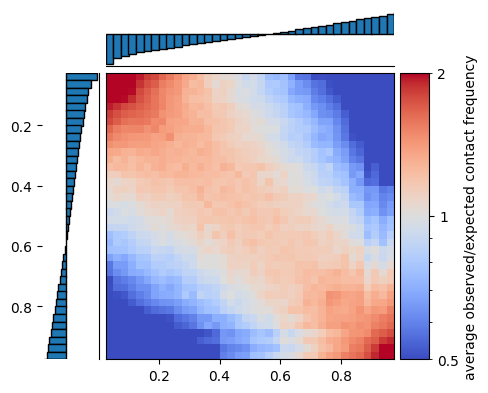

In [36]:
saddleplot(Homo_eigenvector_track_500kb,
           Homo_interaction_sum_500kb/Homo_interaction_count_500kb,
           N_GROUPS,
           qrange=(Q_LO,Q_HI),
           cbar_kws={'label':'average observed/expected contact frequency'}
          );
plt.savefig('../plots/Homo_saddle_plot_500kb.pdf', transparent=True, bbox_inches='tight')


In [12]:
Het_1_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_1/Het_1.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Het_1_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_1/Het_1.bins.gc.500000.tsv'
Het_1_genome_gc_500kb=pd.read_csv(Het_1_genome_gc_500kb_file, sep='\t')


Het_1_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_1/Het_1.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_1/Het_1.500000.cis.lam.txt']
Het_1_cis_eigs_eigenvectors_500kb=pd.read_csv(Het_1_cis_eigs_500kb_files[0], sep='\t')
with open(Het_1_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Het_1_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Het_1_cis_eigs_results_500kb = [Het_1_cis_eigs_eigenvalues,Het_1_cis_eigs_eigenvectors_500kb]
Het_1_eigenvector_track_500kb =Het_1_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Het_1_cvd_500kb = cooltools.expected_cis(
        clr=Het_1_clr_500kb,
        view_df=view_df,
    nproc=40
)

Het_1_interaction_sum_500kb, Het_1_interaction_count_500kb =  cooltools.saddle(
        Het_1_clr_500kb,
        Het_1_cvd_500kb,
        Het_1_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


In [13]:
Het_2_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_2/Het_2.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Het_2_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_2/Het_2.bins.gc.500000.tsv'
Het_2_genome_gc_500kb=pd.read_csv(Het_2_genome_gc_500kb_file, sep='\t')


Het_2_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_2/Het_2.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_2/Het_2.500000.cis.lam.txt']
Het_2_cis_eigs_eigenvectors_500kb=pd.read_csv(Het_2_cis_eigs_500kb_files[0], sep='\t')
with open(Het_2_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Het_2_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Het_2_cis_eigs_results_500kb = [Het_2_cis_eigs_eigenvalues,Het_2_cis_eigs_eigenvectors_500kb]
Het_2_eigenvector_track_500kb =Het_2_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Het_2_cvd_500kb = cooltools.expected_cis(
        clr=Het_2_clr_500kb,
        view_df=view_df,
    nproc=40
)

Het_2_interaction_sum_500kb, Het_2_interaction_count_500kb =  cooltools.saddle(
        Het_2_clr_500kb,
        Het_2_cvd_500kb,
        Het_2_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


In [14]:
Het_3_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_3/Het_3.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Het_3_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_3/Het_3.bins.gc.500000.tsv'
Het_3_genome_gc_500kb=pd.read_csv(Het_3_genome_gc_500kb_file, sep='\t')


Het_3_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_3/Het_3.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Het_3/Het_3.500000.cis.lam.txt']
Het_3_cis_eigs_eigenvectors_500kb=pd.read_csv(Het_3_cis_eigs_500kb_files[0], sep='\t')
with open(Het_3_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Het_3_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Het_3_cis_eigs_results_500kb = [Het_3_cis_eigs_eigenvalues,Het_3_cis_eigs_eigenvectors_500kb]
Het_3_eigenvector_track_500kb =Het_3_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Het_3_cvd_500kb = cooltools.expected_cis(
        clr=Het_3_clr_500kb,
        view_df=view_df,
    nproc=40
)

Het_3_interaction_sum_500kb, Het_3_interaction_count_500kb =  cooltools.saddle(
        Het_3_clr_500kb,
        Het_3_cvd_500kb,
        Het_3_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


In [15]:
Homo_1_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_1/Homo_1.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Homo_1_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_1/Homo_1.bins.gc.500000.tsv'
Homo_1_genome_gc_500kb=pd.read_csv(Homo_1_genome_gc_500kb_file, sep='\t')


Homo_1_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_1/Homo_1.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_1/Homo_1.500000.cis.lam.txt']
Homo_1_cis_eigs_eigenvectors_500kb=pd.read_csv(Homo_1_cis_eigs_500kb_files[0], sep='\t')
with open(Homo_1_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Homo_1_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Homo_1_cis_eigs_results_500kb = [Homo_1_cis_eigs_eigenvalues,Homo_1_cis_eigs_eigenvectors_500kb]
Homo_1_eigenvector_track_500kb =Homo_1_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Homo_1_cvd_500kb = cooltools.expected_cis(
        clr=Homo_1_clr_500kb,
        view_df=view_df,
    nproc=40
)

Homo_1_interaction_sum_500kb, Homo_1_interaction_count_500kb =  cooltools.saddle(
        Homo_1_clr_500kb,
        Homo_1_cvd_500kb,
        Homo_1_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


In [16]:
Homo_2_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_2/Homo_2.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Homo_2_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_2/Homo_2.bins.gc.500000.tsv'
Homo_2_genome_gc_500kb=pd.read_csv(Homo_2_genome_gc_500kb_file, sep='\t')


Homo_2_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_2/Homo_2.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_2/Homo_2.500000.cis.lam.txt']
Homo_2_cis_eigs_eigenvectors_500kb=pd.read_csv(Homo_2_cis_eigs_500kb_files[0], sep='\t')
with open(Homo_2_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Homo_2_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Homo_2_cis_eigs_results_500kb = [Homo_2_cis_eigs_eigenvalues,Homo_2_cis_eigs_eigenvectors_500kb]
Homo_2_eigenvector_track_500kb =Homo_2_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Homo_2_cvd_500kb = cooltools.expected_cis(
        clr=Homo_2_clr_500kb,
        view_df=view_df,
    nproc=40
)

Homo_2_interaction_sum_500kb, Homo_2_interaction_count_500kb =  cooltools.saddle(
        Homo_2_clr_500kb,
        Homo_2_cvd_500kb,
        Homo_2_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


In [17]:
Homo_3_clr_500kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_3/Homo_3.valid_pairs.5000.zoomify.mcool::resolutions/500000")

Homo_3_genome_gc_500kb_file=f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_3/Homo_3.bins.gc.500000.tsv'
Homo_3_genome_gc_500kb=pd.read_csv(Homo_3_genome_gc_500kb_file, sep='\t')


Homo_3_cis_eigs_500kb_files=[f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_3/Homo_3.500000.cis.vecs.tsv', f'/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/valid_pairs_cooler_cooltools_output/Homo_3/Homo_3.500000.cis.lam.txt']
Homo_3_cis_eigs_eigenvectors_500kb=pd.read_csv(Homo_3_cis_eigs_500kb_files[0], sep='\t')
with open(Homo_3_cis_eigs_500kb_files[1], 'r') as eigenvalue_file:
    Homo_3_cis_eigs_eigenvalues = eigenvalue_file.read()
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors    
Homo_3_cis_eigs_results_500kb = [Homo_3_cis_eigs_eigenvalues,Homo_3_cis_eigs_eigenvectors_500kb]
Homo_3_eigenvector_track_500kb =Homo_3_cis_eigs_results_500kb[1][['chrom','start','end','E1']]

Homo_3_cvd_500kb = cooltools.expected_cis(
        clr=Homo_3_clr_500kb,
        view_df=view_df,
    nproc=40
)

Homo_3_interaction_sum_500kb, Homo_3_interaction_count_500kb =  cooltools.saddle(
        Homo_3_clr_500kb,
        Homo_3_cvd_500kb,
        Homo_3_eigenvector_track_500kb,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
)

INFO:root:creating a Pool of 40 workers
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/expected.py:351: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = dict(iter(bins.groupby("chrom")[clr_weight_name]))
/lustre/home/acct-medlqian/medlqian-loop3/.conda/envs/cooltools/lib/python3.13/site-packages/cooltools/api/saddle.py:92: RuntimeWarning: invalid value encountered in divide
  return obs_mat / exp_mat


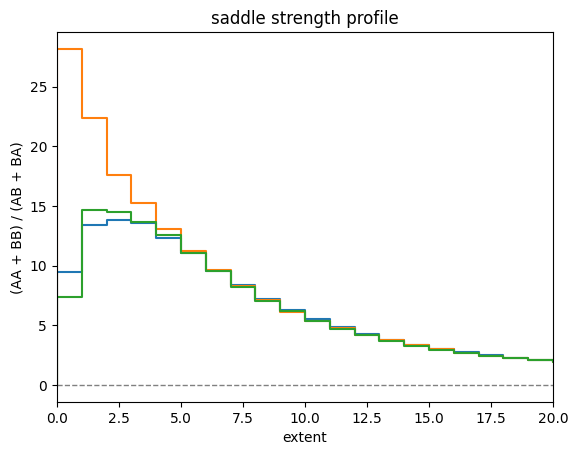

In [18]:
from cooltools.api.saddle import saddle_strength
# at extent=0, this reduces to ((S/C)[0,0] + (S/C)[-1,-1]) / (2*(S/C)[-1,0])

x = np.arange(N_GROUPS + 2)

plt.step(x, saddle_strength(Het_1_interaction_sum_500kb, Het_1_interaction_count_500kb), where='pre')
plt.step(x, saddle_strength(Het_2_interaction_sum_500kb, Het_2_interaction_count_500kb), where='pre')
plt.step(x, saddle_strength(Het_3_interaction_sum_500kb, Het_3_interaction_count_500kb), where='pre')

plt.xlabel('extent')
plt.ylabel('(AA + BB) / (AB + BA)')
plt.title('saddle strength profile')
plt.axhline(0, c='grey', ls='--', lw=1) # Q: is there a reason this is 0 not 1?
plt.xlim(0, len(x)//2); # Q: is this less intuitive than showing for all x, as it converges to no difference (i.e. 1)?
plt.show()

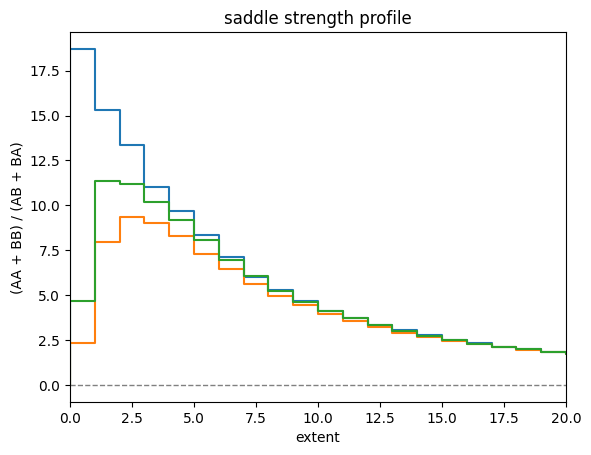

In [20]:
from cooltools.api.saddle import saddle_strength
# at extent=0, this reduces to ((S/C)[0,0] + (S/C)[-1,-1]) / (2*(S/C)[-1,0])

x = np.arange(N_GROUPS + 2)

plt.step(x, saddle_strength(Homo_1_interaction_sum_500kb, Homo_1_interaction_count_500kb), where='pre')
plt.step(x, saddle_strength(Homo_2_interaction_sum_500kb, Homo_2_interaction_count_500kb), where='pre')
plt.step(x, saddle_strength(Homo_3_interaction_sum_500kb, Homo_3_interaction_count_500kb), where='pre')

plt.xlabel('extent')
plt.ylabel('(AA + BB) / (AB + BA)')
plt.title('saddle strength profile')
plt.axhline(0, c='grey', ls='--', lw=1) # Q: is there a reason this is 0 not 1?
plt.xlim(0, len(x)//2); # Q: is this less intuitive than showing for all x, as it converges to no difference (i.e. 1)?
plt.show()

In [27]:
# 假设 N_GROUPS = 10, 那么 saddle_strength 长度是 N_GROUPS + 2
x = np.arange(N_GROUPS + 2)

# 获取 saddle_strength 数组
ss_Het_1 = saddle_strength(Het_1_interaction_sum_500kb, Het_1_interaction_count_500kb)

# 求 extent <= 10 的数值总和
total_ss_Het_1 = np.sum(ss_Het_1[x <= 10])
print(total_ss_Het_1)

105.03389502081157


In [28]:
# 假设 N_GROUPS = 10, 那么 saddle_strength 长度是 N_GROUPS + 2
x = np.arange(N_GROUPS + 2)

# 获取 saddle_strength 数组
ss_Het_2 = saddle_strength(Het_2_interaction_sum_500kb, Het_2_interaction_count_500kb)

# 求 extent <= 10 的数值总和
total_ss_Het_2 = np.sum(ss_Het_2[x <= 10])
print(total_ss_Het_2)

138.85893013259297


In [29]:
# 假设 N_GROUPS = 10, 那么 saddle_strength 长度是 N_GROUPS + 2
x = np.arange(N_GROUPS + 2)

# 获取 saddle_strength 数组
ss_Het_3 = saddle_strength(Het_3_interaction_sum_500kb, Het_3_interaction_count_500kb)

# 求 extent <= 10 的数值总和
total_ss_Het_3 = np.sum(ss_Het_3[x <= 10])
print(total_ss_Het_3)

104.7789571327735


In [26]:
# 假设 N_GROUPS = 10, 那么 saddle_strength 长度是 N_GROUPS + 2
x = np.arange(N_GROUPS + 2)

# 获取 saddle_strength 数组
ss_Homo_1 = saddle_strength(Homo_1_interaction_sum_500kb, Homo_1_interaction_count_500kb)

# 求 extent <= 10 的数值总和
total_ss_Homo_1 = np.sum(ss_Homo_1[x <= 10])
print(total_ss_Homo_1)

65.65694359932759


In [30]:
# 假设 N_GROUPS = 10, 那么 saddle_strength 长度是 N_GROUPS + 2
x = np.arange(N_GROUPS + 2)

# 获取 saddle_strength 数组
ss_Homo_2 = saddle_strength(Homo_2_interaction_sum_500kb, Homo_2_interaction_count_500kb)

# 求 extent <= 10 的数值总和
total_ss_Homo_2 = np.sum(ss_Homo_2[x <= 10])
print(total_ss_Homo_2)

99.42388285362239


In [31]:
# 假设 N_GROUPS = 10, 那么 saddle_strength 长度是 N_GROUPS + 2
x = np.arange(N_GROUPS + 2)

# 获取 saddle_strength 数组
ss_Homo_3 = saddle_strength(Homo_3_interaction_sum_500kb, Homo_3_interaction_count_500kb)

# 求 extent <= 10 的数值总和
total_ss_Homo_3 = np.sum(ss_Homo_3[x <= 10])
print(total_ss_Homo_3)

77.59145052686024


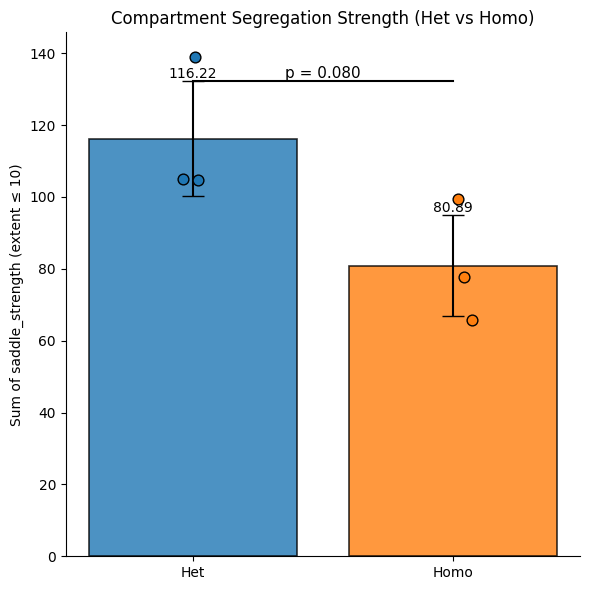

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# extent 最大值（如 N_GROUPS = 10）
extent_min = 10
x = np.arange(N_GROUPS + 2)

# === 每组样本的 saddle_strength（已计算） ===
Het_vals = [
    np.sum(ss_Het_1[x > extent_min]),
    np.sum(ss_Het_2[x > extent_min]),
    np.sum(ss_Het_3[x > extent_min])
]

Homo_vals = [
    np.sum(ss_Homo_1[x > extent_min]),
    np.sum(ss_Homo_2[x > extent_min]),
    np.sum(ss_Homo_3[x > extent_min])
]

# === 均值与标准差 ===
means = [np.mean(Het_vals), np.mean(Homo_vals)]
stds = [np.std(Het_vals), np.std(Homo_vals)]

# === 进行 t 检验 ===
t_stat, p_value = ttest_ind(Het_vals, Homo_vals, equal_var=False)

# === 绘图设置 ===
fig, ax = plt.subplots(figsize=(6, 6))
bar_positions = np.arange(2)
bar_width = 0.6

# 自定义颜色
colors = ['#1f77b4', '#ff7f0e']  # 蓝色、橙色

# 画 barplot
bars = ax.bar(bar_positions, means, yerr=stds, capsize=8, alpha=0.8,
              color=colors, edgecolor='black', linewidth=1.2)

# 画散点
for i, (vals, color) in enumerate(zip([Het_vals, Homo_vals], colors)):
    x_jitter = np.random.normal(loc=bar_positions[i], scale=0.05, size=len(vals))
    ax.scatter(x_jitter, vals, color=color, edgecolor='black', s=60, zorder=10)

# 添加平均值标注
for i, mean in enumerate(means):
    ax.text(bar_positions[i], mean + stds[i] + 0.01, f'{mean:.2f}', ha='center', va='bottom', fontsize=10)

# 添加 p 值注释
y_max = max(means[i] + stds[i] for i in range(2)) + 0.05
ax.plot([bar_positions[0], bar_positions[1]], [y_max, y_max], color='black')
ax.text(np.mean(bar_positions), y_max + 0.01, f'p = {p_value:.3f}', ha='center', va='bottom', fontsize=11)

# 美化图像
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Het', 'Homo'])
ax.set_ylabel('Sum of saddle_strength (extent ≤ 10)')
ax.set_title('Compartment Segregation Strength (Het vs Homo)')
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig('../plots/saddle_strength_Het_vs_Homo_barplot.pdf', dpi=300, bbox_inches='tight')
plt.show()
